In [79]:
#importnig libs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm

# Task 1

Retention – один из самых важных показателей в компании. 
Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [13]:
reg_path = 'problem1-reg_data(1).csv'
auth_path = 'problem1-auth_data(1).csv'

In [14]:
reg_df = pd.read_csv(reg_path, sep = ";")
auth_df = pd.read_csv(auth_path, sep = ";")

In [15]:
print(f"Shape of the registrations is {reg_df.shape}")
print(f"Shape of the authorizations is {auth_df.shape}")

Shape of the registrations is (1000000, 2)
Shape of the authorizations is (9601013, 2)


проверим пустые значения

In [16]:
print(auth_df.isna().sum()) 
print(reg_df.isna().sum())

auth_ts    0
uid        0
dtype: int64
reg_ts    0
uid       0
dtype: int64


Пороверим нет ли дутпликатов в нашем датафрейме авторизаций

In [17]:
reg_df.drop_duplicates(subset = ['uid']).shape

(1000000, 2)

видим что ничего не изменилось как только мы дропнули дупликаты => айдишники уникальны

Теперь приводим данные к нужному формату

In [18]:
reg_df.dtypes

reg_ts    int64
uid       int64
dtype: object

In [19]:
auth_df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [20]:
reg_df.loc[:, 'reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')
auth_df.loc[:, 'auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')

Мерджим датафреймы

In [21]:
merged = reg_df.merge(auth_df, on='uid', how='left')

In [22]:
merged['month'] = merged['reg_ts'].dt.month
merged['year'] = merged['reg_ts'].dt.year

In [23]:
merged

,reg_ts,uid,auth_ts,month,year
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,11,1998
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,7,1999
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46,7,1999
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15,7,1999
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39,7,1999
...,...,...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54,9,2020
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46,9,2020
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39,9,2020
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31,9,2020


In [24]:
def weighted_retention_rate(auth_data, reg_data, cohorts):
    """
    Вычисляет средний взвешенный показатель retention n-ного дня для нескольких когорт.

    Параметры:
    auth_data (str): Путь к файлу с данными по логам.
    reg_data (str): Путь к файлу с данными по датам регистрации.
    cohorts (dict): Словарь, где ключами являются названия когорт, а значениями являются кортежи
                    с месяцем, годом, start_date (начальной датой) и finish_date (конечной датой) 
                    для каждой когорты.
    Возвращает:
    DataFrame со средним взвешенным показателем retention n-ного дня для каждой когорты.
    """
    all_cohorts_data = []
    
    for cohort_name, (month_num, year_num, start_date, finish_date) in cohorts.items():
        # Загружаем данные по датам регистрации
        reg = pd.read_csv(reg_data, sep=';')

        # Переводим столбец в нужный формат даты из unix time
        reg.loc[:, 'reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s')

        # Загружаем данные по логам 
        auth = pd.read_csv(auth_data, sep=';')
        # Переводим столбец в нужный формат даты из unix time
        auth.loc[:, 'auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s')

        # Примерживаем одну таблицу к другой
        merged = reg.merge(auth, on='uid', how='left')
        
        # Добавляем столбцы с месяцем и годом регистрации, чтобы выделить когорту
        merged['month'] = merged['reg_ts'].dt.month
        merged['year'] = merged['reg_ts'].dt.year
        
        # Добавляем фильтр на месяц, год, начальную и конечную даты
        merged = merged.query('month == @month_num & year == @year_num & reg_ts >= @start_date &\
            reg_ts <= @finish_date')
        
        # Убираем из столбцов с датами время
        merged.loc[:, 'reg_ts'] = merged['reg_ts'].dt.date
        merged.loc[:, 'auth_ts'] = merged['auth_ts'].dt.date
        
        # Считаем разницу между датами в днях для понимания того, retention какого дня надо посчитать
        merged['days_diff'] = merged['auth_ts'] - merged['reg_ts']
        # Убираем лишнее
        merged = merged.dropna().drop_duplicates()
        

        # Считаем общее кол-во юзеров, зарегистрировавшихся в конкретный день
        reg_counts = merged.groupby('reg_ts', as_index=False).\
            agg({'uid': 'nunique'}).rename(columns={'uid': 'users_count'})

        # Считаем кол-во вернувшихся в приложение юзеров через конкретное число дней для каждого дня регистрации
        merged = merged.groupby(['reg_ts', 'days_diff']).\
            agg({'uid': 'nunique'}).rename(columns={'uid': 'returning_users'}).reset_index()
        
        # Добавляем к таблице число зарегистрировавшихся юзеров
        merged = merged.merge(reg_counts, on='reg_ts', how='left')
        
        # Удаляем строки с пропущенными значениями
        merged = merged.dropna()
        
        # Считаем retention_rate
        merged['retention_rate'] = merged['returning_users'] / merged['users_count'] * 100
        # Округляем
        merged['retention_rate'] = merged['retention_rate'].round(2)
        
        # Делаем проверку на ноль для users_count
        merged = merged[merged['users_count'] != 0]
        
        # Считаем взвешенный retention
        merged = merged[['days_diff', 'users_count', 'retention_rate']]
        weighted_retention = merged.groupby('days_diff').\
            apply(lambda x: round(sum(x['retention_rate'] * x['users_count']) / sum(x['users_count']), 2)).\
            reset_index(name='weighted_retention')
        
        weighted_retention['cohort'] = cohort_name
        all_cohorts_data.append(weighted_retention)
    
    # Объединяем все DataFrame'ы в один
    result_df = pd.concat(all_cohorts_data, ignore_index=True)
    
    return result_df


In [25]:
# Вызываем функцию и получаем взвешенный retention_rate n-ого дня
# где days_diff - n-ный день
result = weighted_retention_rate(auth_path, reg_path, 
                        {'cohort1': (1, 2020, "2020-01-14", "2020-01-28"),
                         'cohort2': (2, 2020, "2020-02-14", "2020-02-28")})
result

C:\Users\nurbe\AppData\Local\Temp\ipykernel_3652\3502702215.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'reg_ts'] = merged['reg_ts'].dt.date
C:\Users\nurbe\AppData\Local\Temp\ipykernel_3652\3502702215.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'auth_ts'] = merged['auth_ts'].dt.date
C:\Users\nurbe\AppData\Local\Temp\ipykernel_3652\3502702215.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,days_diff,weighted_retention,cohort
0,0 days,100.00,cohort1
1,1 days,2.02,cohort1
2,2 days,3.93,cohort1
3,3 days,4.83,cohort1
4,4 days,5.40,cohort1
...,...,...,...
472,218 days,1.43,cohort2
473,219 days,1.07,cohort2
474,220 days,1.31,cohort2
475,221 days,0.88,cohort2


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_stacked_area_plot_seaborn(df):
    # Преобразование days_diff в количество дней, если это timedelta
    if pd.api.types.is_timedelta64_dtype(df['days_diff']):
        df['days_diff'] = df['days_diff'].dt.days

    # Отфильтровываем данные, чтобы оставить только записи после первого дня
    df = df[df['days_diff'] > 0]
    
    # Проверяем, что необходимые столбцы присутствуют в DataFrame
    if not {'days_diff', 'weighted_retention', 'cohort'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'days_diff', 'weighted_retention', and 'cohort' columns.")
    
    # Сортируем DataFrame по дням и когортам для корректной визуализации
    df.sort_values(by=['cohort', 'days_diff'], inplace=True)

    # Готовим данные
    pivot_df = df.pivot(index='days_diff', columns='cohort', values='weighted_retention').fillna(0)
    pivot_df_cumsum = pivot_df.cumsum(axis=1)

    # Генерация stacked area plot
    plt.figure(figsize=(15, 8))
    
    # Сначала рисуем области
    for i, column in enumerate(pivot_df_cumsum.columns[::-1]):
        sns.lineplot(data=pivot_df_cumsum, x=pivot_df_cumsum.index, y=column, sort=False, lw=1)
    # Форматирование осей
    plt.title('Stacked Area Plot of Weighted Retention Rate by Cohort using Seaborn')
    plt.xlabel('Days since First Day')
    plt.ylabel('Cumulative Weighted Retention Rate (%)')
    plt.legend(labels=pivot_df_cumsum.columns, loc='upper right')
    plt.tight_layout()
    plt.show()


C:\Users\nurbe\AppData\Local\Temp\ipykernel_3652\1781284341.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['cohort', 'days_diff'], inplace=True)


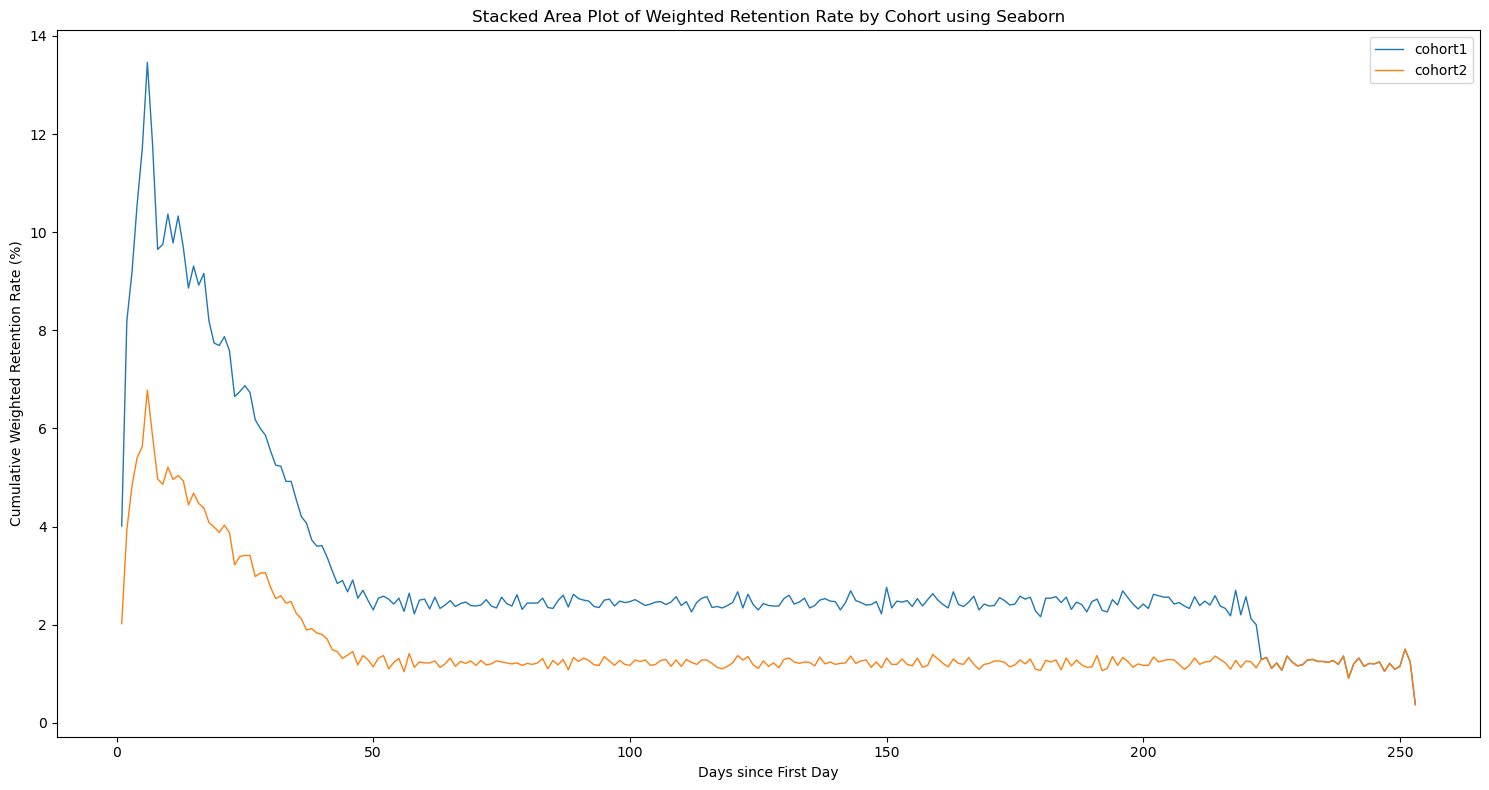

In [27]:
create_stacked_area_plot_seaborn(result)


# Task 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

In [30]:
data = pd.read_csv("task2(1).csv", sep = ';')
data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [31]:
# Создание отдельных датафреймов для контрольной и тестовой групп
control = data.query("testgroup == 'a'")
test = data.query("testgroup == 'b'")

control_revenue = control.revenue
test_revenue = test.revenue

In [32]:
# Расчет ARPU
arpu_control = control.revenue.mean()
arpu_test = test.revenue.mean()

print(f"ARPU Control: {arpu_control}")
print(f"ARPU Test: {arpu_test}")

ARPU Control: 25.413719736965806
ARPU Test: 26.75128659327863


In [33]:
# Расчет ARPPU
paying_users_control = control_revenue[control_revenue > 0].count()
paying_users_test = test_revenue[test_revenue > 0].count()

arppu_control = control_revenue.sum() / paying_users_control
arppu_test = test_revenue.sum() / paying_users_test

print(f"ARPPU Control: {arppu_control}")
print(f"ARPPU Test: {arppu_test}")

ARPPU Control: 2663.9984439834025
ARPPU Test: 3003.6581717451522


In [51]:
paying_control_r = control_revenue[control_revenue > 0]

In [53]:
paying_test_r = test_revenue[test_revenue > 0]

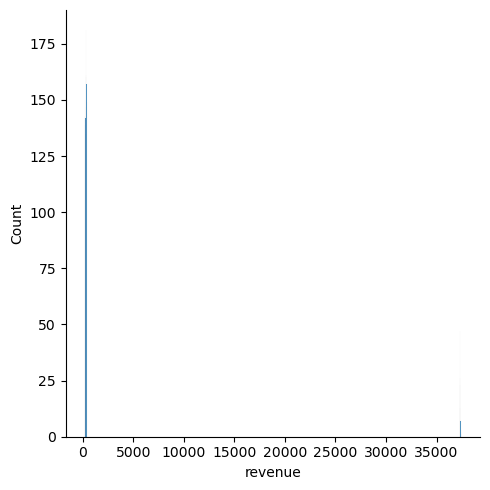

In [65]:
sns.displot(paying_control_r)

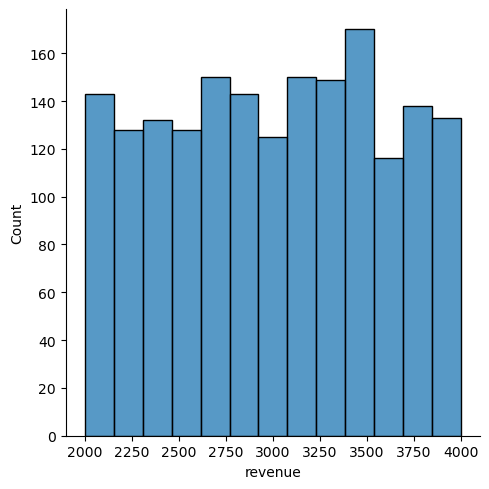

In [66]:
sns.displot(paying_test_r)

In [56]:
paying_control_r.max()

37433

In [57]:
paying_test_r.max()

4000

В контрольной группе 6.3796680497925315% платящих пользователей плятят выше 30000 рублей
Это 89.37077665950378% от всей выручки


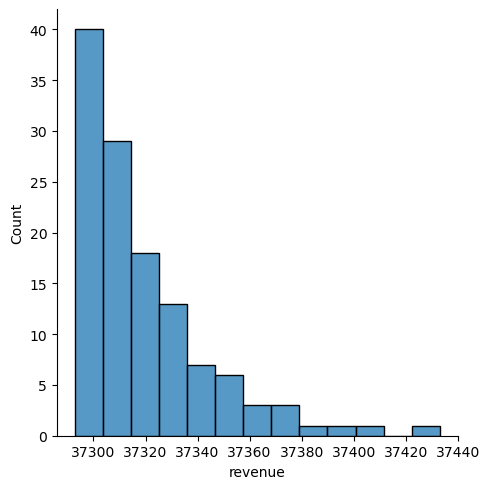

In [76]:
rich_control = paying_control_r[paying_control_r >= 30000]
sns.displot(rich_control)
print(f"В контрольной группе {100*rich_control.count()/paying_users_control}% платящих пользователей плятят выше 30000 рублей")
print(f"Это {rich_control.sum()*100/paying_control_r.sum()}% от всей выручки")

В контрольной группе 93.62033195020747% платящих пользователей плятят выше 30000 рублей
Это 10.629223340496232% от всей выручки


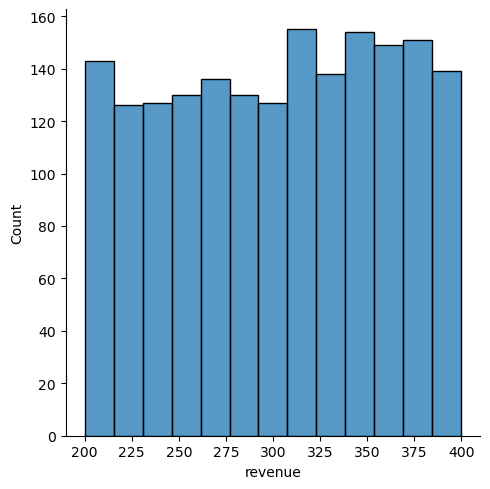

In [75]:
not_rich_control = paying_control_r[paying_control_r < 30000]
sns.displot(not_rich_control)
print(f"В контрольной группе {100*not_rich_control.count()/paying_users_control}% платящих пользователей плятят выше 30000 рублей")
print(f"Это {not_rich_control.sum()*100/paying_control_r.sum()}% от всей выручки")

# Заметим что в тестовой группе примерно одинаковое колличество в каждой платящей подгруппе. Диапазон в платящей группе от 2000 до 4000 рублей. 

# Однако в контрольной дела обстоят совершенно по другому. В контрольной группе 93% платящих пользователей с диапазоном 200-400 и 6% пользователей с диапазоном 37300-37400

In [34]:
# Расчет конверсии
conversion_control = control[control['revenue'] > 0].shape[0] / control.shape[0]
conversion_test = test[test['revenue'] > 0].shape[0] / test.shape[0]

print(f"Конверсия в контрольной группе: {conversion_control:.2%}")
print(f"Конверсия в тестовой группе: {conversion_test:.2%}")

Конверсия в контрольной группе: 0.95%
Конверсия в тестовой группе: 0.89%


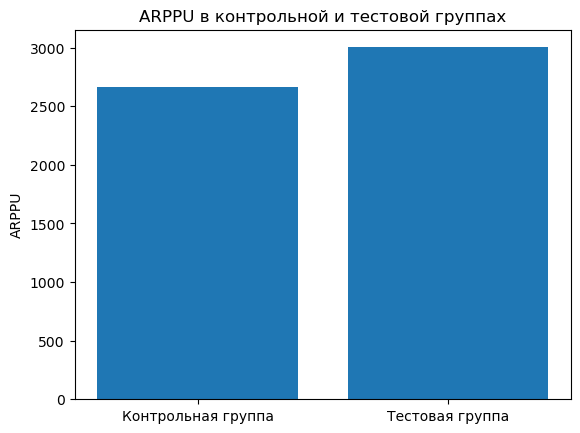

In [35]:
# Визуализация ARPPU
plt.bar(['Контрольная группа', 'Тестовая группа'], [arppu_control, arppu_test])
plt.title('ARPPU в контрольной и тестовой группах')
plt.ylabel('ARPPU')
plt.show()

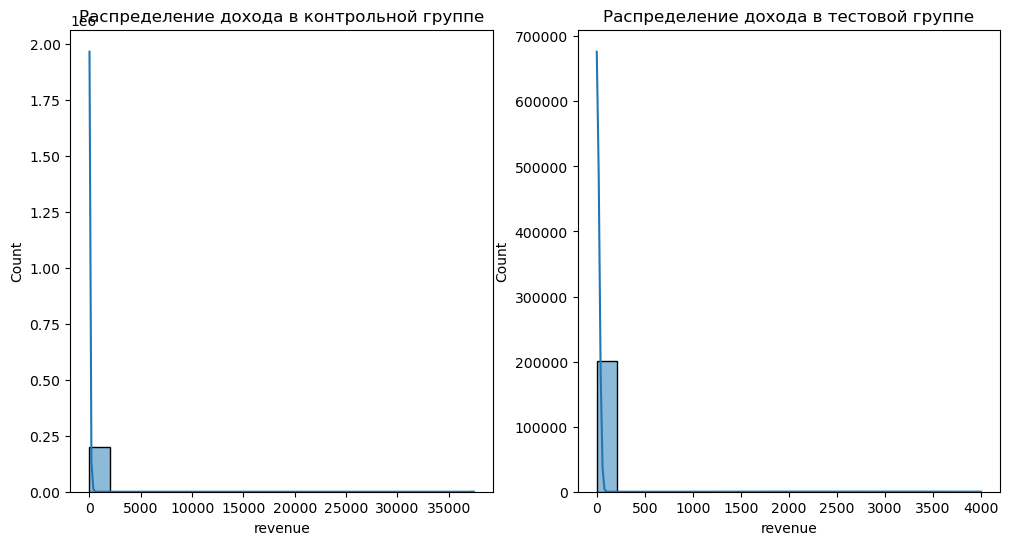

In [36]:
# Визуализация распределения дохода для оценки нормальности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(control['revenue'], kde=True)
plt.title('Распределение дохода в контрольной группе')
plt.subplot(1, 2, 2)
sns.histplot(test['revenue'], kde=True)
plt.title('Распределение дохода в тестовой группе')
plt.show()

In [77]:
# Проверка гомогенности дисперсий
levene_test = stats.levene(control['revenue'], test['revenue'])
print("Levene's Test: ", levene_test)

#

Levene's Test:  LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)


Дисперсии в целом равны поэтому можем использовать класичесский t-test не используя модификацию уэлча

In [38]:
# Проверка на нормальность распределения
print("Shapiro-Wilk Test - Control ARPU:", stats.shapiro(control['revenue']))
print("Shapiro-Wilk Test - Test ARPU:", stats.shapiro(test['revenue']))

Shapiro-Wilk Test - Control ARPU: ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)
Shapiro-Wilk Test - Test ARPU: ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)


C:\Users\nurbe\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


этот тест может быть не таким точным для больших выботок, так что проверим значение нормальности по QQ-графику

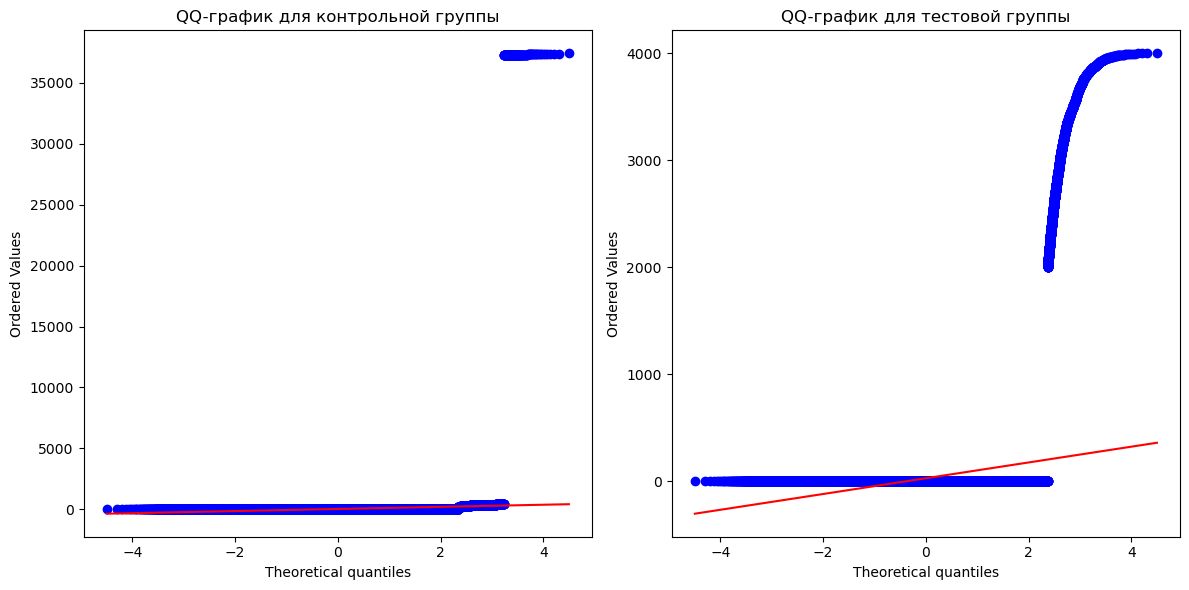

In [39]:
# Функция для создания QQ-графика с использованием Seaborn
def qqplot(data, ax, label):
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f'QQ-график для {label}')

# Создание QQ-графиков
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

qqplot(control['revenue'], ax[0], 'контрольной группы')
qqplot(test['revenue'], ax[1], 'тестовой группы')

plt.tight_layout()
plt.show()

Визуально и на цифрах видно что распределение не нормальное

# Но так как в выборке больше 400К пользователей, т.е. большая выборка, нормальностью распределения можно пребречь

Но важно учитывать то что для Т-теста обязательным условием является нормальность распределения средних

Для того чтобы узнать нормально ли распределены выборочные средние ис пользуем bootstrap

In [40]:
#сюда мы будем складывать результаты
sample_means_control = []
sample_means_target = []

#повторяем процесс 10000 раз
for i in range(10000):
    #симулируем выборку
    sample_data_control = data.query("testgroup == 'a'").sample(frac=1, replace=True)
    sample_data_test = data.query("testgroup == 'b'").sample(frac=1, replace=True)

    #считаем показатель
    sample_mean_control = sample_data_control.revenue.mean()
    sample_mean_test = sample_data_test.revenue.mean()

    #добавляем результат в список
    sample_means_control.append(sample_mean_control)
    sample_means_target.append(sample_mean_test)
    


Populating the interactive namespace from numpy and matplotlib


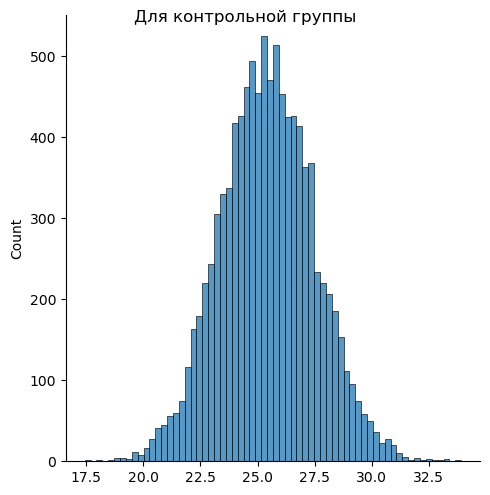

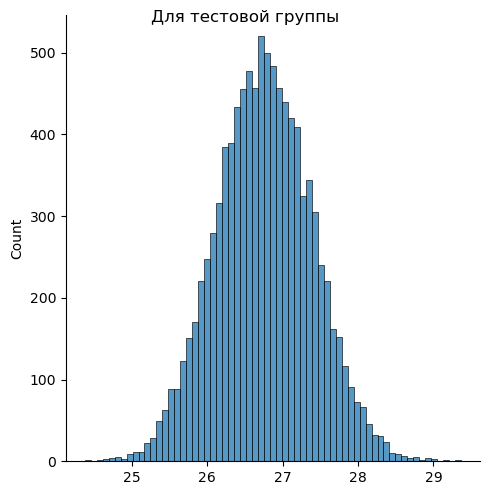

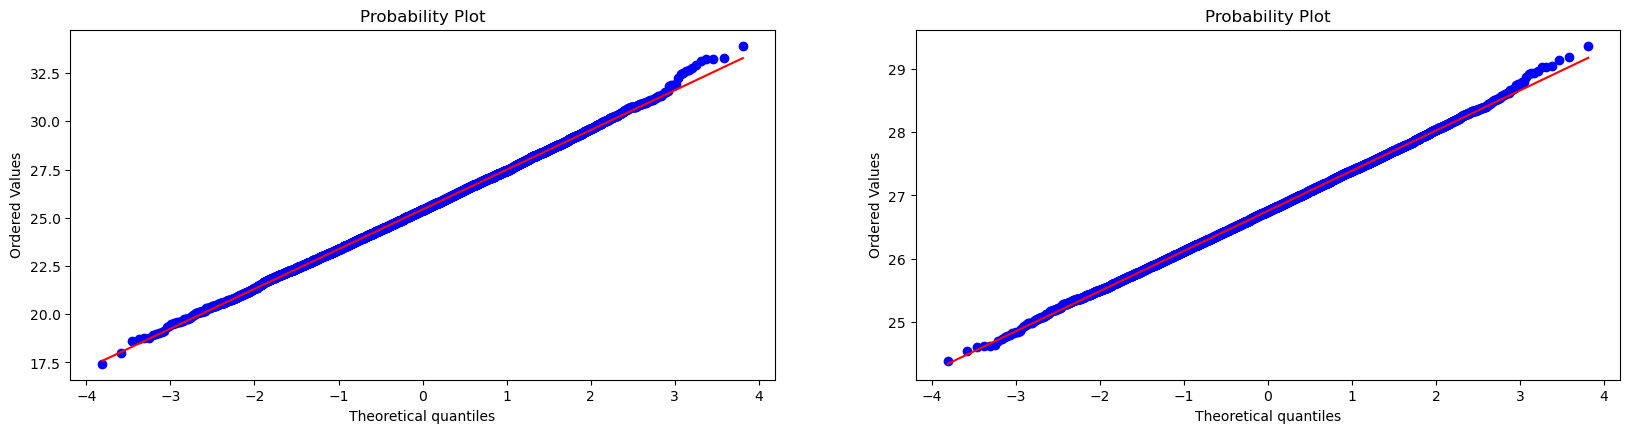

Тест на нормальность распределения control группы: W = 1.000 , p-value = 0.025 => стат значимо не нормально
Тест на нормальность распределения test группы: W = 1.000 , p-value = 0.279 => не стат значимо, нормальное


C:\Users\nurbe\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
%pylab inline

g1 = sns.displot(data=sample_means_control)
g1.fig.suptitle("Для контрольной группы")  # Установка заголовка графика

plt.show()  # Отображение графика

# Создание графика для тестовой группы
g2 = sns.displot(data=sample_means_target)
g2.fig.suptitle("Для тестовой группы")  # Установка заголовка графика

plt.show()  # Отображение графика

# Q-Q plots for control and target groups
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения test группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

# Тут важно отметить, что по ЦПТ мы можем пренебречь нормальностью средних и говорить что средние в любом случае нормально распределены, так как выборка достаточно большая

Исходя из выводов выше, мы можем использовать красичесский t-test

In [42]:
stats.ttest_ind(control.revenue, test.revenue, equal_var= True)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

# Так как занчение p-value выше критического значения в 0.05 у нас есть основания не отвергать нулевую гипотезу и полагать что revenue статистически не отличается в выборках

Так же нам нужно учитывать что конверсия в контрольной группе выше чем в тестовой

In [43]:
from scipy.stats import norm

def z_test_proportions(n1, x1, n2, x2):
    """
    Выполняет z-тест для сравнения пропорций двух независимых выборок.
    
    Параметры:
    n1 (int): Размер первой группы (контрольной).
    x1 (int): Количество успехов (например, платящих пользователей) в первой группе.
    n2 (int): Размер второй группы (тестовой).
    x2 (int): Количество успехов во второй группе.
    
    Возвращает:
    tuple: Z-статистика и p-значение.
    """
    # Расчет пропорций
    p1 = x1 / n1
    p2 = x2 / n2

    # Объединенная пропорция
    p_combined = (x1 + x2) / (n1 + n2)

    # Стандартная ошибка объединенной пропорции
    se = (p_combined * (1 - p_combined) * (1 / n1 + 1 / n2)) ** 0.5

    # Z-статистика
    z_stat = (p1 - p2) / se

    # P-значение
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))

    return z_stat, p_value

x1 = control.query("revenue > 0").shape[0]
x2 = test.query("revenue > 0").shape[0]

n1 = control.shape[0]
n2 = test.shape[0]

# Выполнение z-теста
z_stat, p_value = z_test_proportions(n1, x1, n2, x2)

print("Z-статистика:", z_stat)
print("P-значение:", p_value)

Z-статистика: 2.108028495889841
P-значение: 0.035028524642854775


Так как p-значение (0.035) меньше стандартного уровня значимости 0.05, мы можем заключить, что различия в конверсиях между контрольной и тестовой группами являются статистически значимыми. Это означает, что наблюдаемые различия в процентах платящих пользователей в этих двух группах вряд ли являются результатом случайных колебаний и могут быть связаны с введенными акционными предложениями. 

# Вывод: хоть наше revenue не отличается по группам, в контрольной группе конверсия статистически значимо выше. 

# Для бизнес-пользователя:
* Очень рискованно выбирать акционные предложения контрольной группы. Это вызовет нестабильность для бизнеса и сценарий, в котором меньше 10% клиентов делают 89% всей выручки.
* С другой стороны для роста компании, не выгодно чтобы пользователи платили мало.

# Стоит изучить акционные предложения для обоих групп и составить план который не отталкивает криентов платящих выше 30000, но и не отпугнуть клиентов с тестовой группы.

# Task 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**1. Метрики вовлеченности:**

* **DAU/MAU (Daily/Monthly Active Users):** Процент активных пользователей, участвовавших в событии.
* **Средняя продолжительность сессии:** Сколько времени в среднем игроки тратили на событие.
* **Количество сыгранных уровней:** Общее количество уровней, пройденных всеми игроками.
* **Коэффициент завершения:** Процент игроков, которые завершили все уровни события.

**2. Метрики монетизации:**

* **ARPU:** Средний доход с пользователя, полученный за время события.
* **Количество покупок:** Общее количество покупок, совершенных игроками во время события.

**3. Метрики удовлетворенности:**

* **Количество положительных/отрицательных отзывов:** Общее количество положительных и отрицательных отзывов об игре.
* **Средняя оценка события:** Оценка события игроками по 10-балльной шкале.





**Влияние усложнения механики:**

**1. Метрики вовлеченности:**

* **DAU/MAU:** Ожидается снижение, так как усложнение может отпугнуть некоторых игроков.
* **Средняя продолжительность сессии:** Может возрасти, так как игрокам потребуется больше времени на прохождение уровней.
* **Количество сыгранных уровней:** Может снизиться, так как не все игроки смогут пройти все уровни.
* **Коэффициент завершения:** Значительно снизится, так как усложнение сделает завершение события более сложным.

**2. Метрики монетизации:**

* **ARPU:** Может возрасти, так как усложнение может стимулировать игроков к покупке дополнительных предметов.
* **Количество покупок:** Может возрасти, так как игрокам потребуется больше попыток для прохождения уровней.
* **Средний чек:** Может возрасти, так как игрокам могут понадобиться более дорогие предметы для прохождения уровней.
* **ROI:** Может возрасти, так как при увеличении ARPU и количества покупок расходы на разработку события могут окупиться быстрее.

**3. Метрики удовлетворенности:**

* **NPS:** Может снизиться, так как усложнение может негативно сказаться на впечатлениях игроков.
* **Количество положительных/отрицательных отзывов:** Ожидается увеличение количества отрицательных отзывов.
* **Средняя оценка события:** Значительно снизится.

**Дополнительные метрики:**

* **Количество откатов:** Сколько раз игроки откатывались назад на несколько уровней.
* **Среднее время прохождения одного уровня:** Сколько времени в среднем игроки тратили на прохождение одного уровня.
* **Уровень сложности, на котором игроки чаще всего отказываются от игры:** Определение проблемных уровней.



**Важно:**

* При внесении изменений в механику события необходимо тщательно отслеживать все метрики, чтобы оценить влияние этих изменений на игроков.
* Необходимо провести A/B-тестирование, чтобы сравнить результаты нового события с результатами предыдущих событий.
* На основе полученных данных необходимо сделать выводы о том, насколько эффективным было событие, и внести необходимые изменения в механику будущих событий.
* Не забудьте также отслеживать отзывы игроков в социальных сетях и на форумах, чтобы получить более полную картину их мнения о событии.

